In [4]:
import os, re, pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure NLTK data is available
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')
nltk.download('punkt_tab') # Added this line to download the missing resource

STOPWORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()


# 3: Load dataset + inspect
# 1) Load dataset
DATA_PATH = Path(r"/content/customer_reviews.csv")
print('Loading:', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('\nShape:', df.shape)
print('\nColumns:\n', df.columns.tolist())
display(df.head())

# 4: Infer text and label columns and create label
# 2) Infer text column and label column (rating -> binary label if needed)

# Find likely text column
text_candidates = [c for c in df.columns if c.lower() in ('review','text','comment','feedback')]
if text_candidates:
    text_col = text_candidates[0]
else:
    # fallback: choose first object / string column
    obj_cols = [c for c in df.columns if df[c].dtype == 'object']
    if len(obj_cols) == 0:
        raise ValueError('No text-like column found in dataset.')
    text_col = obj_cols[0]

print('Using text column:', text_col)

# Find label candidates
label_col = None
if any(c.lower() in ('sentiment','label','sentiment_label', 'feeling') for c in df.columns):
    label_col = [c for c in df.columns if c.lower() in ('sentiment','label','sentiment_label', 'feeling')][0]
elif 'rating' in [c.lower() for c in df.columns]:
    # pick the column name that equals (case-insensitive) 'rating'
    label_col = [c for c in df.columns if c.lower() == 'rating'][0]
else:
    # check for numeric columns with limited unique values (1-5 ratings)
    numeric_candidates = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    for c in numeric_candidates:
        if df[c].nunique() <= 6:
            label_col = c
            break

print('Detected label column (or rating):', label_col)

# Create 'text' and 'label' standardized columns
df = df.rename(columns={text_col: 'text'})
if label_col is None:
    raise ValueError('No label or rating column found. Please provide a rating or sentiment column.')
else:
    # if label column is named sentiment and contains strings like 'positive'/'negative'
    if df[label_col].dtype == object:
        df['label'] = df[label_col].astype(str).str.lower().map(lambda x: 1 if 'pos' in x else (0 if 'neg' in x else np.nan))
    else:
        # numeric: map ratings -> sentiment (4-5 positive, 1-2 negative, drop 3 if present)
        def rating_to_label(r):
            try:
                r = float(r)
                if r >= 4.0:
                    return 1
                elif r <= 2.0:
                    return 0
                else:
                    return np.nan
            except:
                return np.nan
        df['label'] = df[label_col].apply(rating_to_label)

print('\nAfter label mapping, value counts:')
print(df['label'].value_counts(dropna=False))
# Drop neutral / NaN labels
df = df[['text','label']].dropna().reset_index(drop=True)
print('\nFinal dataset shape (after dropping neutral):', df.shape)
display(df.head())


# 5: Preprocessing functions and apply
# 3) Preprocessing functions

URL_RE = re.compile(r'https?://\S+|www\.\S+')
HTML_RE = re.compile(r'<.*?>')
NON_ALPHANUM = re.compile(r'[^a-z0-9 ]')

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = URL_RE.sub(' ', text)
    text = HTML_RE.sub(' ', text)
    text = text.replace('\n',' ').replace('\r',' ')
    text = NON_ALPHANUM.sub(' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_and_lemmatize(text: str) -> str:
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    lemmas = [LEMMATIZER.lemmatize(t) for t in tokens]
    return ' '.join(lemmas)

# Apply
df['clean_text'] = df['text'].apply(clean_text).apply(tokenize_and_lemmatize)
display(df[['text','clean_text','label']].head())

Loading: /content/customer_reviews.csv

Shape: (110, 2)

Columns:
 ['review', 'feeling']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,review,feeling
0,Great product! Highly recommend it.,positive
1,Excellent service and fast delivery.,positive
2,Love the quality of this item.,positive
3,Amazing experience exceeded my expectations.,positive
4,The best customer support I have ever encounte...,positive


Using text column: review
Detected label column (or rating): feeling

After label mapping, value counts:
label
1.0    50
0.0    50
NaN    10
Name: count, dtype: int64

Final dataset shape (after dropping neutral): (100, 2)


,text,label
0,Great product! Highly recommend it.,1.0
1,Excellent service and fast delivery.,1.0
2,Love the quality of this item.,1.0
3,Amazing experience exceeded my expectations.,1.0
4,The best customer support I have ever encounte...,1.0


,text,clean_text,label
0,Great product! Highly recommend it.,great product highly recommend,1.0
1,Excellent service and fast delivery.,excellent service fast delivery,1.0
2,Love the quality of this item.,love quality item,1.0
3,Amazing experience exceeded my expectations.,amazing experience exceeded expectation,1.0
4,The best customer support I have ever encounte...,best customer support ever encountered,1.0


In [5]:
URL_RE = re.compile(r'https?://\S+|www\.\S+')
HTML_RE = re.compile(r'<.*?>')
NON_ALPHANUM = re.compile(r'[^a-z0-9 ]')

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = URL_RE.sub(' ', text)
    text = HTML_RE.sub(' ', text)
    text = text.replace('\n',' ').replace('\r',' ')
    text = NON_ALPHANUM.sub(' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_and_lemmatize(text: str) -> str:
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    lemmas = [LEMMATIZER.lemmatize(t) for t in tokens]
    return ' '.join(lemmas)

# Apply
df['clean_text'] = df['text'].apply(clean_text).apply(tokenize_and_lemmatize)
display(df[['text','clean_text','label']].head())

,text,clean_text,label
0,Great product! Highly recommend it.,great product highly recommend,1.0
1,Excellent service and fast delivery.,excellent service fast delivery,1.0
2,Love the quality of this item.,love quality item,1.0
3,Amazing experience exceeded my expectations.,amazing experience exceeded expectation,1.0
4,The best customer support I have ever encounte...,best customer support ever encountered,1.0


Train size: 80 Test size: 20
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best params: {'clf__C': 5.0, 'tfidf__max_df': 0.8, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Best CV F1: 0.5384615384615384

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.62      0.80      0.70        10

    accuracy                           0.65        20
   macro avg       0.66      0.65      0.64        20
weighted avg       0.66      0.65      0.64        20


Confusion matrix:
[[5 5]
 [2 8]]

Accuracy: 0.65
ROC AUC: 0.6699999999999999


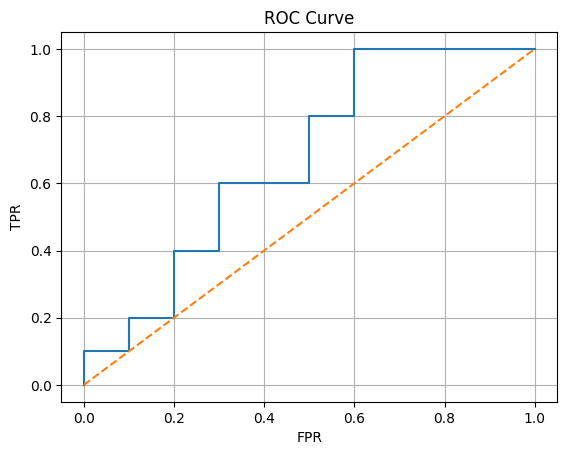

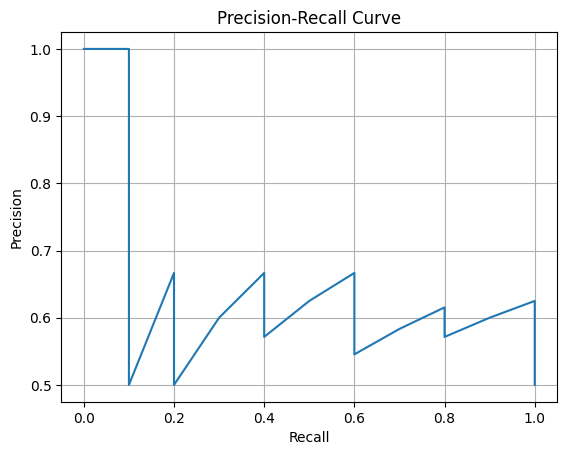

Top positive features:
excellent (1.863)
impressed (1.676)
expectation (1.576)
satisfied (1.500)
highly (1.450)
outstanding (1.363)
friendly (1.294)
exceptional (1.180)
love (1.180)
quick (1.179)
well (1.087)
exceeded (1.029)
great (0.979)
earlier (0.967)
purchase (0.950)
thrilled (0.928)
company (0.921)
needed (0.882)
happier (0.882)
exactly (0.882)

Top negative features:
issue (-1.386)
disappointing (-1.195)
advertised (-1.157)
damaged (-1.130)
unusable (-1.129)
concern (-1.127)
unresponsive (-1.127)
match (-1.046)
flimsy (-1.019)
poorly (-1.006)
overpriced (-0.996)
rude (-0.895)
unhelpful (-0.895)
use (-0.884)
seller (-0.884)
disappointed (-0.858)
overall (-0.858)
waste (-0.846)
money (-0.846)
refund (-0.799)
Saved pipeline to sentiment_pipeline_uploaded_dataset.pkl


,text,cleaned,pred,proba_positive
0,I love this product,love product,1,0.714359
1,This is the worst thing I bought,worst thing bought,0,0.466221


'/content/sentiment_analysis_uploaded_dataset.ipynb'

In [9]:
import nbformat as nbf
nb = nbf.v4.new_notebook()

# 6: Train-test split
# 4) Train-test split
X = df['clean_text'].values
y = df['label'].astype(int).values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train size:', len(X_train), 'Test size:', len(X_test))


# 7: Pipeline + GridSearch
# 5) Build pipeline and run GridSearchCV for best params
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
])

param_grid = {
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__min_df': [1,2],
    'tfidf__max_df': [0.8,0.95],
    'clf__C': [0.1,1.0,5.0]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print('\nBest params:', grid.best_params_)
print('Best CV F1:', grid.best_score_)
best = grid.best_estimator_

# 8: Evaluation
# 6) Evaluate on test set
y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:,1]

print('\nClassification report:')
print(classification_report(y_test, y_pred))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nAccuracy:', accuracy_score(y_test, y_pred))
try:
    print('ROC AUC:', roc_auc_score(y_test, y_proba))
except:
    pass

# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# 9: Top features
# 7) Top features inspection
tfidf = best.named_steps['tfidf']
clf = best.named_steps['clf']
feature_names = tfidf.get_feature_names_out()
coefs = clf.coef_[0]

top_pos = np.argsort(coefs)[-20:][::-1]
top_neg = np.argsort(coefs)[:20]

print('Top positive features:')
for i in top_pos[:20]:
    print(feature_names[i], f'({coefs[i]:.3f})')

print('\nTop negative features:')
for i in top_neg[:20]:
    print(feature_names[i], f'({coefs[i]:.3f})')


# 10: Save model and helper
# 8) Save pipeline and helper function
MODEL_PATH = 'sentiment_pipeline_uploaded_dataset.pkl'
with open(MODEL_PATH,'wb') as f:
    pickle.dump(best, f)
print('Saved pipeline to', MODEL_PATH)

def predict_texts(texts):
    if isinstance(texts, str):
        texts = [texts]
    cleaned = [tokenize_and_lemmatize(clean_text(t)) for t in texts]
    preds = best.predict(cleaned)
    probs = best.predict_proba(cleaned)[:,1]
    return pd.DataFrame({'text': texts, 'cleaned': cleaned, 'pred': preds, 'proba_positive': probs})

# Demo
display(predict_texts(['I love this product', 'This is the worst thing I bought']))

nb['cells'] = cells

output_path = "/content/sentiment_analysis_uploaded_dataset.ipynb"
with open(output_path, "w", encoding="utf-8") as f:
    nbf.write(nb, f)

output_path